# Retinal OCT using VGG19

### Import libraries

In [1]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

import tensorflow as tf
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator, load_img
from scipy.io._test_fortran import __test_fortran_error
from tensorflow.python.ops.gen_dataset_ops import model_dataset

In [2]:
base_dir = os.path.join('data/OCT2017 /')

In [3]:
train_dir = os.path.join(base_dir + "train/")

In [4]:
test_dir = os.path.join(base_dir + "test/")

In [5]:
validation_dir = os.path.join(base_dir + "val/")

In [6]:
vgg19 = tf.keras.applications.VGG19(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (150,150,3),
    pooling = None
)

2022-05-07 11:47:52.406569: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-07 11:47:52.406826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [7]:
vgg19.trainable = False

In [8]:
model_vgg = tf.keras.models.Sequential([

    vgg19,
    tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = 'same'),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),# modifying final layers of VGG-19
    tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = 'same'),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

In [9]:
metrics = ['accuracy',
                tfa.metrics.F1Score(num_classes = 4),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall()]

In [10]:
model_vgg.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = metrics)
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 128)         589952    
                                                                 
 p_re_lu (PReLU)             (None, 4, 4, 128)         2048      
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          73792     
                                                                 
 p_re_lu_1 (PReLU)           (None, 4, 4, 64)          1024      
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 100)               1

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255)
#rotation_range=0.2,width_shift_range=0.05,height_shift_range=0.05, shear_range=0.05,zoom_range=0.05
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), class_mode = 'categorical', batch_size = 32)

Found 83484 images belonging to 4 classes.


In [12]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size = (150, 150), class_mode = 'categorical', batch_size = 16)

Found 32 images belonging to 4 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (150, 150), class_mode = 'categorical', batch_size = 32)

Found 968 images belonging to 4 classes.


In [14]:
earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, mode='max', min_delta=0.1, restore_best_weights = True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='data/vgg19_model.h5',
                                                                   save_weights_only=True, monitor='accuracy',
                                                                   mode='max', save_best_only=True)
history_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch = (83484/32),
    epochs = 50,
    validation_data = test_generator,
    validation_steps = (968/32),
    workers=4,
    #max_queue_size=100,
    verbose = True,
    callbacks=[model_checkpoint_callback, earlyStopCallback])

Epoch 1/50


2022-05-07 11:47:55.291397: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-07 11:47:55.996206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2609/2608 [==============================] - ETA: 0s - loss: 0.4763 - accuracy: 0.8232 - f1_score: 0.7184 - precision: 0.8560 - recall: 0.7900

2022-05-07 11:54:44.539784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2608/2608 [==============================] - 415s 158ms/step - loss: 0.4763 - accuracy: 0.8232 - f1_score: 0.7184 - precision: 0.8560 - recall: 0.7900 - val_loss: 0.1957 - val_accuracy: 0.9390 - val_f1_score: 0.9386 - val_precision: 0.9447 - val_recall: 0.9360
Epoch 2/50
2608/2608 [==============================] - 413s 158ms/step - loss: 0.3600 - accuracy: 0.8709 - f1_score: 0.8018 - precision: 0.8870 - recall: 0.8552 - val_loss: 0.2431 - val_accuracy: 0.9050 - val_f1_score: 0.9044 - val_precision: 0.9100 - val_recall: 0.8988
Epoch 3/50
2608/2608 [==============================] - 413s 158ms/step - loss: 0.3278 - accuracy: 0.8829 - f1_score: 0.8217 - precision: 0.8961 - recall: 0.8701 - val_loss: 0.2077 - val_accuracy: 0.9329 - val_f1_score: 0.9323 - val_precision: 0.9422 - val_recall: 0.9267
Epoch 4/50
2608/2608 [==============================] - 424s 162ms/step - loss: 0.3056 - accuracy: 0.8905 - f1_score: 0.8337 - precision: 0.9020 - recall: 0.8796 - val_loss: 0.2148 - val_accuracy

Values for VGG-19 based ConvNet


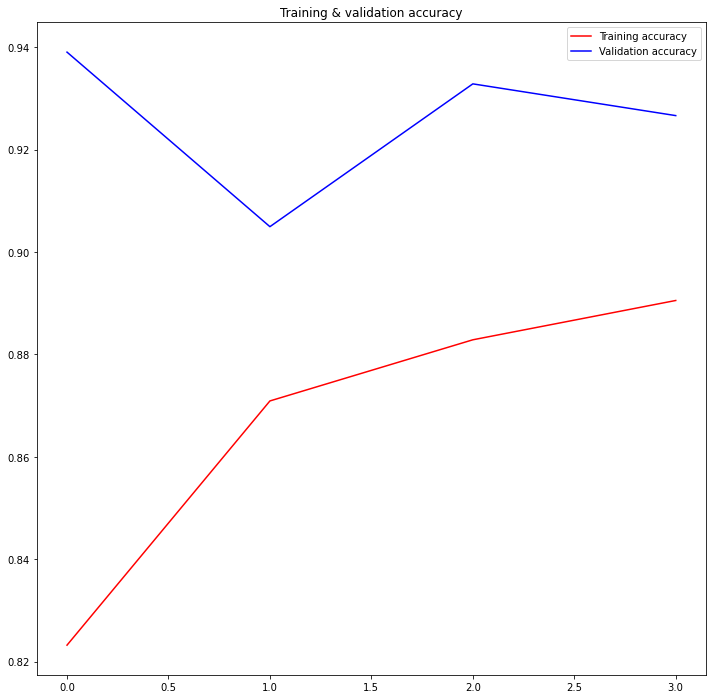

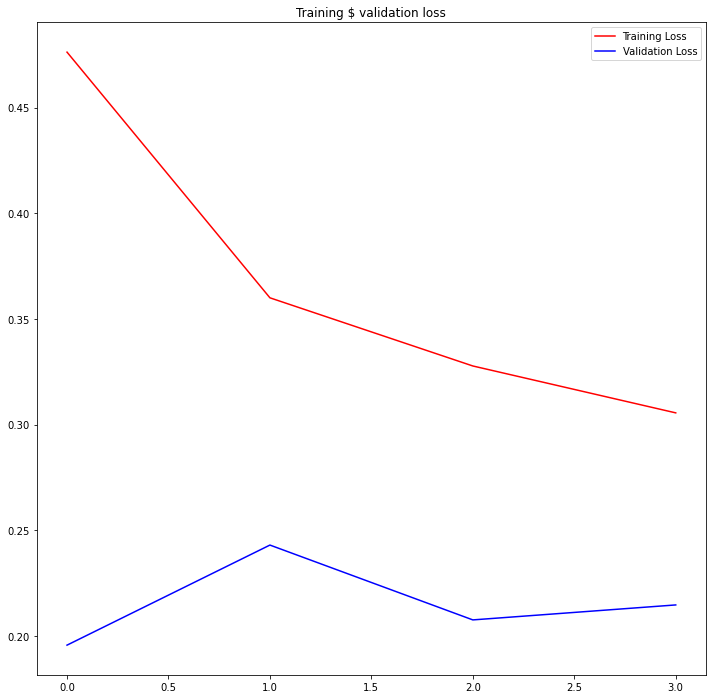

In [15]:
print("Values for VGG-19 based ConvNet")
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12,12))

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training & validation accuracy')
plt.legend()

plt.figure(figsize = (12,12))

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training $ validation loss')
plt.legend()

plt.show()

In [16]:
model_vgg.load_weights('data/vgg19_model.h5')

In [35]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model_vgg.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)

In [36]:
print(len(predicted_classes))
print(predicted_classes)

968
[1 3 1 0 0 3 2 2 0 0 3 1 3 3 2 0 3 0 0 3 3 2 1 2 1 1 1 3 3 2 0 0 2 0 2 2 1
 0 0 3 3 0 3 3 0 0 0 0 3 3 3 3 3 1 2 3 1 1 2 2 2 2 0 3 0 0 3 0 0 2 2 1 0 3
 1 2 0 3 2 3 3 3 0 2 2 3 0 3 2 1 0 3 0 0 0 1 2 0 2 1 3 2 3 1 3 2 3 0 0 1 2
 2 1 0 3 2 3 0 2 3 0 0 3 0 3 2 2 3 0 1 0 3 0 3 0 3 3 2 2 3 3 2 1 2 0 3 0 1
 3 1 3 1 0 1 1 3 2 1 3 2 3 1 0 3 3 1 3 2 2 0 3 2 0 0 2 0 1 3 0 3 3 2 2 3 2
 1 2 2 3 3 0 2 1 2 3 2 0 0 2 3 0 3 2 0 2 3 0 2 0 3 0 3 3 0 3 2 1 0 3 0 3 0
 2 0 0 3 0 0 0 3 1 2 3 0 3 2 0 2 0 3 0 1 3 1 3 2 1 3 1 1 0 2 3 1 3 0 3 0 0
 3 1 1 2 0 3 0 0 2 2 1 0 0 1 1 0 0 2 2 1 0 0 1 1 0 0 2 3 2 0 0 1 2 0 3 3 2
 0 3 3 2 2 0 1 1 1 2 3 3 0 1 1 0 2 0 1 3 1 1 1 3 0 2 1 0 2 3 1 3 0 3 1 0 2
 0 1 1 2 3 3 3 0 2 2 0 2 1 1 0 2 1 2 1 1 0 3 0 3 1 2 2 3 1 0 0 0 0 1 0 1 1
 0 0 0 2 0 0 3 3 2 2 1 3 1 2 2 2 3 1 0 0 3 3 3 0 3 2 3 2 2 3 1 3 2 0 1 1 2
 3 0 1 0 1 0 1 2 3 2 2 1 3 2 0 2 0 2 0 2 2 0 1 2 2 3 0 3 3 3 0 3 3 3 2 2 1
 3 2 2 0 0 1 2 1 0 1 3 0 0 1 0 0 3 3 0 2 0 2 1 0 3 1 0 3 3 3 0 1 1 1 1 2 2
 1 1 3 0 1 3 1 3 0 3 

In [37]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [38]:
print(true_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 

In [39]:
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

         CNV       0.26      0.30      0.27       242
         DME       0.29      0.26      0.27       242
      DRUSEN       0.16      0.14      0.15       242
      NORMAL       0.23      0.25      0.24       242

    accuracy                           0.24       968
   macro avg       0.23      0.24      0.23       968
weighted avg       0.23      0.24      0.23       968



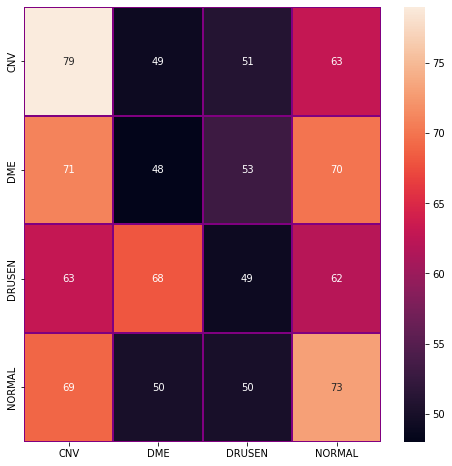

In [22]:
cm = sklearn.metrics.confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8,8))
classes = train_generator.class_indices.keys()
sns.heatmap(cm, fmt='.0f', annot=True, linewidths=0.2, linecolor='purple', xticklabels=classes, yticklabels=classes)
plt.show()

### Heatmaps

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [24]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(path)

    # Display Grad CAM
    display(Image(path))

def get_data_by_category(train_data, category):
    sample = train_data.loc[train_data[category] == 1]
    sample = sample[:5]
    names = sample['filename'].to_numpy()
    labels = sample['label'].to_numpy()

    return names, labels

def number_to_string(label):
    if label == 0:
        return 'CNV'
    elif label == 1:
        return 'DME'
    elif label == 2 :
        return 'DRUSEN'
    elif label == 2 :
        return 'NORMAL'
        return 'nothing'

def visualize_hetmaps(names, labels, img_size, model, last_conv_layer_name):
    i = 0
    for row in names:
        print(row)
        path = train_dir + row
        img_array = get_img_array(path, size=img_size)
        model.layers[-1].activation = None
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        save_and_display_gradcam(path, heatmap, 'data/OCT2017 /predicted/' + row)
        preds = model.predict(img_array)
        y_pred = np.argmax(preds, axis=1)
        print("Predicted:", number_to_string(y_pred[0]))
        print("Original:", labels[i])
        i = i + 1

In [25]:
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 128)         589952    
                                                                 
 p_re_lu (PReLU)             (None, 4, 4, 128)         2048      
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          73792     
                                                                 
 p_re_lu_1 (PReLU)           (None, 4, 4, 64)          1024      
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 100)               1

In [26]:
img_size = (150, 150)
preprocess_input = keras.applications.xception.preprocess_input
last_conv_layer_name = 'conv2d_1'

In [27]:
names = validation_generator.filenames

In [28]:
labels = validation_generator.labels

In [29]:
visualize_hetmaps(names[0:10], labels[0:10], img_size, model_vgg, last_conv_layer_name)

CNV/CNV-6294785-1.jpeg


FileNotFoundError: [Errno 2] No such file or directory: 'data/OCT2017 /predicted/CNV/CNV-6294785-1.jpeg'